# Boort

## S1 processing

* using SNAP and SNAP graph/processing pipeline
* standard steps: Apply precise orbit, thermal noise removal, remove GRD border noise, calibration, terrain correction (DEM: 30m Copernicus global) 10m pixel spacing, subset to region, linear to dB conversion
* calculation of RVI using `create-rvi-tif` python script (example run: `python3 ~/dev/2023_multifrequency/2024-10-14-create-rvi-tif.py --scale log --polarizations VH VV "./data-boort-processed/Subset_S1A_IW_GRDH_1SDV_20210806T194104_20210806T194129_039113_049D9A_1D7A_Orb_NR_Cal_TC_dB.tif" "./data-boort-processed/Subset_S1A_IW_GRDH_1SDV_20210806T194104_20210806T194129_039113_049D9A_1D7A_Orb_NR_Cal_TC_dB-RVI.tif"`)


## NovaSAR processing

* ARD data provided by CSIRO
* calibration from DN
* conversion to dB
* local incidence angle from ARD annotation files
* calculation of RVI using `create-rvi-threepol.py` und `create-rvi.py` scripts
    * example runs: `$ python3 ~/dev/2023_multifrequency/2024-10-14-create-rvi-novasar-threepol-tif.py --polarization VV HH HV --scale log \
CEOS-ARD_NRB_v5.5_NovaSAR_01_25520_scd_27_210807_124636_VV_HH_HV_D_L/Measurement/CEOS-ARD_NRB_v5.5_Gamma0_VV_N1_25520_scd_27_D_L_20210807T124636-db.tif \
CEOS-ARD_NRB_v5.5_NovaSAR_01_25520_scd_27_210807_124636_VV_HH_HV_D_L/Measurement/CEOS-ARD_NRB_v5.5_Gamma0_HH_N1_25520_scd_27_D_L_20210807T124636-db.tif \
CEOS-ARD_NRB_v5.5_NovaSAR_01_25520_scd_27_210807_124636_VV_HH_HV_D_L/Measurement/CEOS-ARD_NRB_v5.5_Gamma0_HV_N1_25520_scd_27_D_L_20210807T124636-db.tif \
CEOS-ARD_NRB_v5.5_NovaSAR_01_25520_scd_27_210807_124636_VV_HH_HV_D_L/CEOS-ARD_NRB_v5.5_Gamma0_N1_25520_scd_27_D_L_20210807T124636-RVI.tif`
    * `$ python3 ~/dev/2023_multifrequency/2024-10-14-create-rvi-tif.py --polarizations HH HV --scale log \
"CEOS-ARD_NRB_v5.5_NovaSAR_01_25520_scd_27_210807_124636_VV_HH_HV_D_L/Measurement/CEOS-ARD_NRB_v5.5_Gamma0_HH_N1_25520_scd_27_D_L_20210807T124636-db.tif" \
"CEOS-ARD_NRB_v5.5_NovaSAR_01_25520_scd_27_210807_124636_VV_HH_HV_D_L/Measurement/CEOS-ARD_NRB_v5.5_Gamma0_HV_N1_25520_scd_27_D_L_20210807T124636-db.tif" \
"CEOS-ARD_NRB_v5.5_NovaSAR_01_25520_scd_27_210807_124636_VV_HH_HV_D_L/CEOS-ARD_NRB_v5.5_Gamma0_N1_25520_scd_27_D_L_20210807T124636-RVIhhhv.tif"`

## Sentinel-2 processing/NDVI calculation

* using custom methods in each notebook
* masking using SCL layer

# Python imports

In [1]:
import geopandas as gpd
from datetime import date
import pandas as pd
from pathlib import Path
import numpy as np
import rasterio
import rasterio.mask
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [2]:
from multifrequtils import (
    compute_zonal_stats_rasterio, 
    open_s2_and_save_ndvi_img,
    scatterplot_nice,
    get_s2_zip_files,
    get_s2_ndvi_files,
    get_filtered_pearsons_r,
    add_cr,
    )

In [3]:
pd.set_option("display.max_rows", 10)
pd.set_option("display.min_rows", 4)

# Definitions

In [4]:
data_dir = Path("/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/")
assert data_dir.is_dir()

In [5]:
s2_img_dir = data_dir / "data s2 boort"
s1_img_dir = data_dir / "data-boort-processed"
novasar_img_dir = data_dir / "data novasar boort"
vector_file_path = data_dir / 'fields-boort.geojson'
classification_file = data_dir / "classifications" / "2024-10-14-CropType_Boort2021_CropGrassland_XMeans_5Clusters_100000TrainingPixels_AreaSmall.tif"

In [6]:
assert classification_file.is_file()

In [7]:
today_isostr = date.today().isoformat()
fig_out_dir = data_dir / f"{today_isostr}-figures-boort"
fig_out_dir.mkdir(exist_ok=True)

In [8]:
correlation_coeffs = list()

In [9]:
polygons = gpd.read_file(vector_file_path)
polygons

,area_ha,polygon_id,geometry
0,73.843229,0,"POLYGON ((143.76899 -35.81024, 143.76937 -35.8..."
1,69.254254,1,"POLYGON ((143.77284 -35.78547, 143.77269 -35.7..."
...,...,...,...
172,3.040469,172,"POLYGON ((144.16363 -35.7604, 144.16367 -35.76..."
173,2.931517,173,"POLYGON ((144.16578 -35.76034, 144.16567 -35.7..."


In [10]:
polygons["area_ha"] = polygons.to_crs('epsg:32754').geometry.area / 10_000

In [11]:
polygons["area_ha"].median(), polygons["area_ha"].mean()

(16.43860891227293, 31.49198033290769)

In [12]:
polygons["area_ha"].quantile([0., 0.333, 0.5, 0.55, 0.666, 1.])

0.000      1.590766
0.333      9.913763
0.500     16.438609
0.550     21.932087
0.666     40.029092
1.000    120.787217
Name: area_ha, dtype: float64

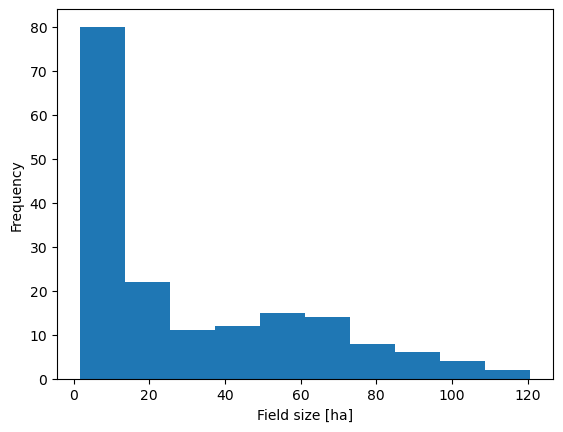

In [13]:
polygons["area_ha"].plot.hist(bins=10)
plt.xlabel("Field size [ha]")
plt.savefig(fig_out_dir / "field-polygons-size-histogram.eps")

# Statistic extraction

## Get raster file paths

In [14]:
def get_novasar_ard_raster_files(novasar_img_dir, use_db_files=False, use_georeferenced=False):
    raster_files, metadata_files = list(), list()
    possible_polarizations = ["HH", "HV", "VV"]
    for novasar_ard_dir in filter(lambda f: f.is_dir(), novasar_img_dir.glob("*ARD*NovaSAR*")):
        assert novasar_ard_dir.is_dir(), ("Expected a dir", novasar_ard_dir)
        
        novasar_subdir = novasar_ard_dir / "Measurement"
        assert novasar_subdir.is_dir(), novasar_subdir
        ard_tifs = list(novasar_subdir.glob("*.tif"))
        if use_db_files:
            ard_tifs = list(filter(lambda f: "db" in f.name, ard_tifs))
        else:
            ard_tifs = list(filter(lambda f: "db" not in f.name, ard_tifs))

        if use_georeferenced:
            filter_func = lambda f: "modified" in f.name or "georef" in f.name
            ard_tifs = list(filter(filter_func, ard_tifs))
        else:
            filter_func = lambda f: "modified" not in f.name and "georef" not in f.name
            ard_tifs = list(filter(filter_func, ard_tifs))

        for pol in possible_polarizations:
            pol_list = list(filter(lambda f: pol in f.name, ard_tifs))
            assert len(pol_list) <= 1, ("At most one file for a polarization", pol_list)
            if len(pol_list) == 1:
                raster_files.append(pol_list[0])
    return raster_files

In [15]:
def get_novasar_rvi_raster_files(novasar_img_dir):
    rvi_files = list()
    for novasar_ard_dir in filter(lambda f: f.is_dir(), novasar_img_dir.glob("*ARD*NovaSAR*")):
        assert novasar_ard_dir.is_dir(), ("Expected a dir", novasar_ard_dir)
        rvi_tifs = list(novasar_ard_dir.glob("*RVI*.tif"))
        # exclude dual pol RVI
        rvi_tifs = list(filter(lambda f: "RVIhhhv" not in f.stem, rvi_tifs))
        rvi_tifs = list(filter(lambda f: "RVIvvhv" not in f.stem, rvi_tifs))
        print(rvi_tifs)
        assert len(rvi_tifs) == 1
        rvi_tif = rvi_tifs[0]
        rvi_files.append(rvi_tif)
    return rvi_files

In [16]:
s2_zip_files = get_s2_zip_files(s2_img_dir)
len(set(s2_zip_files))

4

In [17]:
ndvi_files = get_s2_ndvi_files(ndvi_img_dir=s2_img_dir)
len(set(ndvi_files))

4

In [18]:
ndvi_files

[PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data s2 boort/S2A_MSIL2A_20210808T002101_N0500_R116_T54HYF_20230116T191334.SAFE_NDVI.tif'),
 PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data s2 boort/S2A_MSIL2A_20220528T002721_N0400_R016_T54HYF_20220528T025514.SAFE_NDVI.tif'),
 PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data s2 boort/S2B_MSIL2A_20220120T002049_N0301_R116_T54HYF_20220120T030118.SAFE_NDVI.tif'),
 PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data s2 boort/S2A_MSIL2A_20220604T002101_N0400_R116_T54HYF_20220604T030510.SAFE_NDVI.tif')]

In [19]:
def get_s1_snap_processed_files(s1_dir):
    s1_rasters = list()
    # Subset_S1A_IW_GRDH_1SDV_20220121T194103_20220121T194128_041563_04F181_1F44_Orb_NR_Cal_TC_VV|VH.tif
    # Subset_S1A_IW_GRDH_1SDV_20220602T194106_20220602T194131_043488_05314A_3B6B_Orb_NR_Cal_TC_dB.tif
    # Subset_S1A_IW_GRDH_1SDV_20220121T194103_20220121T194128_041563_04F181_1F44_Orb_NR_Cal_TC_dB.tif
    db_rasters = list(s1_img_dir.glob("Subset_S1A_IW_GRDH*dB.tif"))
    s1_rasters.extend(db_rasters)
    return s1_rasters

s1_raster_files = get_s1_snap_processed_files(s1_dir=s1_img_dir)
s1_rvi_raster_files = list(s1_img_dir.glob("Subset_S1A_IW_GRDH*RVI.tif"))
s1_raster_files, s1_rvi_raster_files

([PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data-boort-processed/Subset_S1A_IW_GRDH_1SDV_20220121T194103_20220121T194128_041563_04F181_1F44_Orb_NR_Cal_TC_dB.tif'),
  PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data-boort-processed/Subset_S1A_IW_GRDH_1SDV_20220602T194106_20220602T194131_043488_05314A_3B6B_Orb_NR_Cal_TC_dB.tif'),
  PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data-boort-processed/Subset_S1A_IW_GRDH_1SDV_20210806T194104_20210806T194129_039113_049D9A_1D7A_Orb_NR_Cal_TC_dB.tif')],
 [PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data-boort-processed/Subset_S1A_IW_GRDH_1SDV_20210806T194104_20210806T194129_039113_049D9A_1D7A_Orb_NR_Cal_TC_dB-RVI.tif'),
  PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data-boort-processed/Subset_S1A_IW_GRDH_1SDV_20220602T194106_20220602T194131_043488_05314A_3B6B_Orb_NR_Cal_TC_dB-RVI.tif'),
  PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-

## Convert NovaSAR ARD to dB tifs

In [20]:
def convert_ard_to_db(novasar_ard_tifpath):
    "CEOS-ARD_NRB_v5.5_Gamma0_HH_N1_26107_scd_32_D_L_20210826T143703.tif"
    db_tifpath = novasar_ard_tifpath.parent / (novasar_ard_tifpath.stem + "-db.tif")
    with rasterio.open(novasar_ard_tifpath) as ds:
        raster_profile = ds.profile
        dn_data = ds.read()
        
    db_data = np.ones_like(dn_data)
    db_data[dn_data != 0] = dn_data[dn_data != 0]

    # equation from metadata, this is euqivalent to the instruction of one email
    # 10 * log10((DN  / 14125.3754)**2)
    # and
    # 20 * log10(DN) - 83
    # are equivalent
    db_data = 20 * np.log10(db_data) - 83
    db_data = np.ma.masked_equal(db_data, 0)
    db_data.mask |= (dn_data == 0)

    raster_profile.update({"dtype": np.float32, "nodata": np.nan})

    with rasterio.open(db_tifpath, "w", **raster_profile) as ds:
        ds.write(db_data)

In [21]:
boort_db_ards = get_novasar_ard_raster_files(novasar_img_dir, use_db_files=True, use_georeferenced=False) + get_novasar_ard_raster_files(novasar_img_dir, use_db_files=True, use_georeferenced=True)
boort_db_ards

[PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data novasar boort/CEOS-ARD_NRB_v5.5_NovaSAR_01_25520_scd_27_210807_124636_VV_HH_HV_D_L/Measurement/CEOS-ARD_NRB_v5.5_Gamma0_HH_N1_25520_scd_27_D_L_20210807T124636-db.tif'),
 PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data novasar boort/CEOS-ARD_NRB_v5.5_NovaSAR_01_25520_scd_27_210807_124636_VV_HH_HV_D_L/Measurement/CEOS-ARD_NRB_v5.5_Gamma0_HV_N1_25520_scd_27_D_L_20210807T124636-db.tif'),
 PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data novasar boort/CEOS-ARD_NRB_v5.5_NovaSAR_01_25520_scd_27_210807_124636_VV_HH_HV_D_L/Measurement/CEOS-ARD_NRB_v5.5_Gamma0_VV_N1_25520_scd_27_D_L_20210807T124636-db.tif'),
 PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data novasar boort/CEOS-ARD_NRB_v5.5_NovaSAR_01_30646_scd_22_220120_124712_VV_HH_HV_D_L/Measurement/CEOS-ARD_NRB_v5.5_Gamma0_HH_N1_30646_scd_22_D_L_20220120T124712-db.tif'),
 PosixPath('/run/media/tom/SSDThomas/scratch

In [22]:
boort_rvi_files = get_novasar_rvi_raster_files(novasar_img_dir)
boort_rvi_files

[PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data novasar boort/CEOS-ARD_NRB_v5.5_NovaSAR_01_25520_scd_27_210807_124636_VV_HH_HV_D_L/CEOS-ARD_NRB_v5.5_Gamma0_N1_25520_scd_27_D_L_20210807T124636-RVI.tif')]
[PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data novasar boort/CEOS-ARD_NRB_v5.5_NovaSAR_01_34338_scd_27_220601_124026_VV_HH_HV_D_L/CEOS-ARD_NRB_v5.5_Gamma0_N1_34338_scd_27_D_L_20220601T124026_modified-RVI.tif')]
[PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data novasar boort/CEOS-ARD_NRB_v5.5_NovaSAR_01_30646_scd_22_220120_124712_VV_HH_HV_D_L/CEOS-ARD_NRB_v5.5_Gamma0_N1_30646_scd_22_D_L_20220120T124712-RVI.tif')]


[PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data novasar boort/CEOS-ARD_NRB_v5.5_NovaSAR_01_25520_scd_27_210807_124636_VV_HH_HV_D_L/CEOS-ARD_NRB_v5.5_Gamma0_N1_25520_scd_27_D_L_20210807T124636-RVI.tif'),
 PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data novasar boort/CEOS-ARD_NRB_v5.5_NovaSAR_01_34338_scd_27_220601_124026_VV_HH_HV_D_L/CEOS-ARD_NRB_v5.5_Gamma0_N1_34338_scd_27_D_L_20220601T124026_modified-RVI.tif'),
 PosixPath('/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data novasar boort/CEOS-ARD_NRB_v5.5_NovaSAR_01_30646_scd_22_220120_124712_VV_HH_HV_D_L/CEOS-ARD_NRB_v5.5_Gamma0_N1_30646_scd_22_D_L_20220120T124712-RVI.tif')]

## Extract Sentinel-2 statistics

In [23]:
stats_s2 = list()
for s2_ndvi_file in tqdm(ndvi_files):
    _stats_s2 = compute_zonal_stats_rasterio(polygons=polygons, raster_path=s2_ndvi_file)
    for d in _stats_s2:
        d["filename"] = s2_ndvi_file.stem
        stats_s2.append(d)
stats_s2_df = pd.DataFrame(stats_s2)
stats_s2_df

100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


,mean,median,count,polygon_id,filename
0,0.907761,0.915452,7389,0,S2A_MSIL2A_20210808T002101_N0500_R116_T54HYF_2...
1,0.926390,0.927503,6928,1,S2A_MSIL2A_20210808T002101_N0500_R116_T54HYF_2...
...,...,...,...,...,...
566,0.928810,0.931876,311,172,S2A_MSIL2A_20220604T002101_N0400_R116_T54HYF_2...
567,0.932867,0.934083,300,173,S2A_MSIL2A_20220604T002101_N0400_R116_T54HYF_2...


In [24]:
_s2_dates = stats_s2_df.loc[:, "filename"].map(lambda f: f.split("_")[2].split("T")[0]).copy()
stats_s2_df.loc[:, "date"] = _s2_dates
stats_s2_df

,mean,median,count,polygon_id,filename,date
0,0.907761,0.915452,7389,0,S2A_MSIL2A_20210808T002101_N0500_R116_T54HYF_2...,20210808
1,0.926390,0.927503,6928,1,S2A_MSIL2A_20210808T002101_N0500_R116_T54HYF_2...,20210808
...,...,...,...,...,...,...
566,0.928810,0.931876,311,172,S2A_MSIL2A_20220604T002101_N0400_R116_T54HYF_2...,20220604
567,0.932867,0.934083,300,173,S2A_MSIL2A_20220604T002101_N0400_R116_T54HYF_2...,20220604


## Extract NovaSAR geocoded statistics

In [25]:
def get_local_incidence_angle_ard(novasar_raster_file, polygons):
    # CEOS-ARD_NRB_v5.5_LocalIncidenceAngle_N1_34338_scd_27_D_L_20220601T124026
    lia_path = next((novasar_raster_file.parent.parent / "Annotation").glob("*LocalIncidenceAngle*"))
    lia_novasar = compute_zonal_stats_rasterio(raster_path=lia_path, polygons=polygons)
    return lia_novasar

In [26]:
stats_novasar = list()
for novasar_raster_file in tqdm(boort_db_ards, desc="NovaSAR pol"):
    _stats_novasar = compute_zonal_stats_rasterio(raster_path=novasar_raster_file, polygons=polygons)
    _lia_novasar = get_local_incidence_angle_ard(novasar_raster_file=novasar_raster_file, polygons=polygons)

    for d, lia in zip(_stats_novasar, _lia_novasar):
        d["filename"] = str(novasar_raster_file.parent) + "-" + novasar_raster_file.stem
        assert d["polygon_id"] == lia["polygon_id"]
        d["local_incidence_angle"] = lia["mean"]
    stats_novasar.extend(_stats_novasar)
stats_novasar_df = pd.DataFrame(stats_novasar)
stats_novasar_df

NovaSAR pol: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


,mean,median,count,polygon_id,filename,local_incidence_angle
0,-8.999235,-8.755424,1841,0,/run/media/tom/SSDThomas/scratch/2024-05-s-ban...,21.270702
1,-4.333942,-4.354588,1720,1,/run/media/tom/SSDThomas/scratch/2024-05-s-ban...,21.253368
...,...,...,...,...,...,...
1219,-10.259328,-10.119110,75,172,/run/media/tom/SSDThomas/scratch/2024-05-s-ban...,20.098450
1220,-11.272655,-11.115467,72,173,/run/media/tom/SSDThomas/scratch/2024-05-s-ban...,20.084316


In [27]:
stats_rvi_novasar = list()
for novasar_rvi_file in tqdm(boort_rvi_files, desc="NovaSAR RVI"):
    print(novasar_rvi_file)
    _stats_rvi = compute_zonal_stats_rasterio(raster_path=novasar_rvi_file, polygons=polygons)
    for d in _stats_rvi:
        d["filename"] = str(novasar_rvi_file.parent) + "-" + novasar_rvi_file.stem
        d["polarization"] = "RVI"
        # novasar_rvi_file.stem: CEOS-ARD_NRB_v5.5_Gamma0_N1_25520_scd_27_D_L_20210807T124636-RVI
        d["date"] = novasar_rvi_file.stem.split("_")[10].split("T")[0]
    stats_rvi_novasar.extend(_stats_rvi)
stats_rvi_novasar = pd.DataFrame(stats_rvi_novasar)
stats_rvi_novasar

NovaSAR RVI:   0%|          | 0/3 [00:00<?, ?it/s]

/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data novasar boort/CEOS-ARD_NRB_v5.5_NovaSAR_01_25520_scd_27_210807_124636_VV_HH_HV_D_L/CEOS-ARD_NRB_v5.5_Gamma0_N1_25520_scd_27_D_L_20210807T124636-RVI.tif


NovaSAR RVI:  33%|███▎      | 1/3 [00:00<00:00,  2.14it/s]

/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data novasar boort/CEOS-ARD_NRB_v5.5_NovaSAR_01_34338_scd_27_220601_124026_VV_HH_HV_D_L/CEOS-ARD_NRB_v5.5_Gamma0_N1_34338_scd_27_D_L_20220601T124026_modified-RVI.tif


NovaSAR RVI:  67%|██████▋   | 2/3 [00:00<00:00,  2.34it/s]

/run/media/tom/SSDThomas/scratch/2024-05-s-band-ndvi/data novasar boort/CEOS-ARD_NRB_v5.5_NovaSAR_01_30646_scd_22_220120_124712_VV_HH_HV_D_L/CEOS-ARD_NRB_v5.5_Gamma0_N1_30646_scd_22_D_L_20220120T124712-RVI.tif


NovaSAR RVI: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


,mean,median,count,polygon_id,filename,polarization,date
0,0.654532,0.493505,1841,0,/run/media/tom/SSDThomas/scratch/2024-05-s-ban...,RVI,20210807
1,0.168715,0.101518,1720,1,/run/media/tom/SSDThomas/scratch/2024-05-s-ban...,RVI,20210807
...,...,...,...,...,...,...,...
405,0.279841,0.116608,77,172,/run/media/tom/SSDThomas/scratch/2024-05-s-ban...,RVI,20220120
406,0.209395,0.136792,77,173,/run/media/tom/SSDThomas/scratch/2024-05-s-ban...,RVI,20220120


In [28]:
stats_novasar_df.loc[:, "polarization"] = stats_novasar_df.loc[:, "filename"].map(lambda f: Path(f).name.split("_")[4]).copy()
stats_novasar_df

,mean,median,count,polygon_id,filename,local_incidence_angle,polarization
0,-8.999235,-8.755424,1841,0,/run/media/tom/SSDThomas/scratch/2024-05-s-ban...,21.270702,HH
1,-4.333942,-4.354588,1720,1,/run/media/tom/SSDThomas/scratch/2024-05-s-ban...,21.253368,HH
...,...,...,...,...,...,...,...
1219,-10.259328,-10.119110,75,172,/run/media/tom/SSDThomas/scratch/2024-05-s-ban...,20.098450,VV
1220,-11.272655,-11.115467,72,173,/run/media/tom/SSDThomas/scratch/2024-05-s-ban...,20.084316,VV


In [29]:
# NovaSAR_01_41494_scd_230127_020220_HH_HV
# CEOS-ARD_NRB_v5.5_Gamma0_HH_N1_34338_scd_27_D_L_20220601T124026_modified-db.tif
_novasar_dates = stats_novasar_df.loc[:, "filename"].map(lambda f: Path(f).name.split("_")[11].split("T")[0]).copy()
stats_novasar_df.loc[:, "date"] = _novasar_dates

stats_novasar_df = add_cr(data=stats_novasar_df, x="median", cross_pol="HV", co_pol="HH", date_col="date", cr_col="CRHH")
stats_novasar_df = add_cr(data=stats_novasar_df, x="median", cross_pol="HV", co_pol="VV", date_col="date", cr_col="CRVV")

stats_novasar_df

,mean,median,count,polygon_id,filename,local_incidence_angle,polarization,date
0,-8.999235,-8.755424,1841,0,/run/media/tom/SSDThomas/scratch/2024-05-s-ban...,21.270702,HH,20210807
1,-4.333942,-4.354588,1720,1,/run/media/tom/SSDThomas/scratch/2024-05-s-ban...,21.253368,HH,20210807
...,...,...,...,...,...,...,...,...
2033,-14.375111,14.186092,77,173,/run/media/tom/SSDThomas/scratch/2024-05-s-ban...,27.321434,CRVV,20220120
2034,-8.904404,10.947514,72,173,/run/media/tom/SSDThomas/scratch/2024-05-s-ban...,20.084316,CRVV,20220601


In [30]:
# add LIA to RVI
stats_rvi_novasar = stats_rvi_novasar.merge(right=stats_novasar_df[["polygon_id", "local_incidence_angle", "date"]].drop_duplicates(),
                                            on=("polygon_id", "date"))
stats_novasar_df = pd.concat([stats_novasar_df, stats_rvi_novasar], axis="rows")

In [31]:
stats_novasar_df.local_incidence_angle.quantile([0, 1])

0.0    15.116064
1.0    28.487249
Name: local_incidence_angle, dtype: float64

In [32]:
stats_novasar_df

,mean,median,count,polygon_id,filename,local_incidence_angle,polarization,date
0,-8.999235,-8.755424,1841,0,/run/media/tom/SSDThomas/scratch/2024-05-s-ban...,21.270702,HH,20210807
1,-4.333942,-4.354588,1720,1,/run/media/tom/SSDThomas/scratch/2024-05-s-ban...,21.253368,HH,20210807
...,...,...,...,...,...,...,...,...
405,0.279841,0.116608,77,172,/run/media/tom/SSDThomas/scratch/2024-05-s-ban...,27.337183,RVI,20220120
406,0.209395,0.136792,77,173,/run/media/tom/SSDThomas/scratch/2024-05-s-ban...,27.321434,RVI,20220120


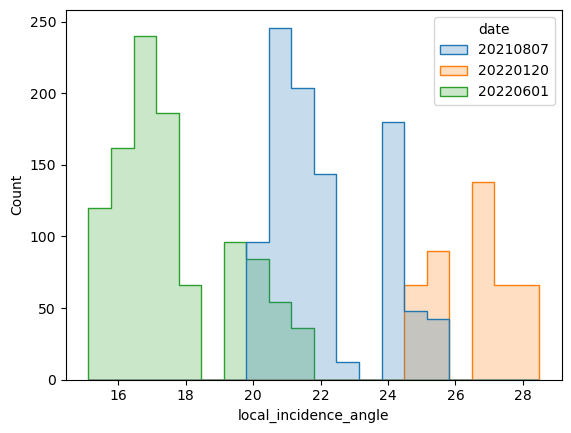

In [33]:
sns.histplot(data=stats_novasar_df, x="local_incidence_angle", hue="date", element="step", bins=20)
plt.savefig(fig_out_dir / "novasar-local_incidence_angle.png")

## Extract Sentinel-1 statistics

In [34]:
def compute_zonal_stats_s1_noise_masked(raster_path, polygons, band_idx=0):
    with rasterio.open(raster_path) as raster_ds:
        raster_crs = raster_ds.crs
        if raster_crs != polygons.crs:
            polygons = polygons.to_crs(raster_crs)
        
        stats_list = []
        
        for _, geom in polygons.iterrows():
            try:
                out_image, out_transform = rasterio.mask.mask(raster_ds, 
                                                              [geom['geometry']], 
                                                              crop=True, 
                                                              filled=False,  # returns masked array
                                                             )
                # also mask NaN values
                out_image.mask |= (~np.isfinite(out_image))
                out_image = out_image[band_idx]  # Assuming single band

                # also mask values <-45dB, as they are below the thermal noise floor
                thermal_noise_floor_mask = (out_image <= -45)
                thermal_noise_floor_fraction = np.sum(thermal_noise_floor_mask) / np.sum(~out_image.mask)
                #if geom['polygon_id'] == 48:
                #    print(f"{geom['polygon_id']=} {thermal_noise_floor_fraction}")
                
                if thermal_noise_floor_fraction > 0.05:
                    # exclude fields that have to many pixels remove due to low backscatter
                    # because they likely have inplausible low mean backscatter values
                    raise UserWarning("To many values are replace with -50dB during thermal noise removal. Ignoring this field!")
                else:
                    # or just mask the few too small backscatter values
                    out_image.mask |= (out_image <= -45)             
                
                # Calculate statistics
                #masked_data = np.ma.masked_array(out_image, mask=(out_image == raster_ds.nodata))
                masked_data = out_image
                mean = np.nanmean(masked_data)
                median = np.ma.median(masked_data)
                count = np.ma.count(masked_data)
            except:# ValueError as e: 
                # Handle case where polygon does not overlap with raster
                mean = np.nan
                count = np.nan
                median = np.nan
    
            stats = {
                'mean': mean,
                'median': median,
                "count": count,
            }
            if "polygon_id" in geom:
                stats["polygon_id"] = geom["polygon_id"]
    
            stats_list.append(stats)

    stats_list = [s for s in stats_list if s["count"] > 10]
    return stats_list

In [35]:
def get_s1_statistcs_dataframe(s1_rasters, polygons):
    stats = list()
    for s1_raster in tqdm(s1_rasters):
        _stats_vh = compute_zonal_stats_s1_noise_masked(raster_path=s1_raster, polygons=polygons, band_idx=0)
        _stats_vv = compute_zonal_stats_s1_noise_masked(raster_path=s1_raster, polygons=polygons, band_idx=1)
        _stats_lia = compute_zonal_stats_rasterio(raster_path=s1_raster, polygons=polygons, band_idx=3)
        for _stats, pol in zip([_stats_vv, _stats_vh], ["VV", "VH"]):
            for d, lia in zip(_stats, _stats_lia):
                d["filename"] = s1_raster.stem
                d["polarization"] = pol
                d["local_incidence_angle"] = lia["mean"]
        stats.extend(_stats_vv)
        stats.extend(_stats_vh)
    stats = pd.DataFrame(stats)
    return stats

def s1_add_date_using_filename(s1_df):
    # Subset_S1A_IW_GRDH_1SDV_20210806T194104_20210806T194129_039113_049D9A_1D7A_Orb_NR_Cal_TC_VH.tif
    date_func = lambda f: f.split("_")[5].split("T")[0]
    s1_dates = s1_df.loc[:, "filename"].map(date_func).copy()
    s1_df.loc[:, "date"] = s1_dates
    return s1_df

def get_s1_rvi_statistics(s1_rvi_rasters, polygons):
    stats = list()
    for s1_rvi_raster in tqdm(s1_rvi_rasters):
        _stats_rvi = compute_zonal_stats_rasterio(raster_path=s1_rvi_raster, polygons=polygons, band_idx=0)
        for d in _stats_rvi:
            d["filename"] = s1_rvi_raster.stem
            d["polarization"] = "RVI"
        stats.extend(_stats_rvi)
    stats = pd.DataFrame(stats)
    return stats
    
def filter_rows_where_data_for_both_polarizations_is_not_present(df):
    """
    t1 = pd.DataFrame([
    {"polygon_id": 1, "date": "20220121", "polarization": "VV"},
    ])
    filter_rows_where_data_for_both_polarizations_is_not_present(t1)
    should be empty!
    """
    stats_out = pd.DataFrame()
    stats_date_out = list()
    
    for date in df.date.unique():
        df_date = df[df.date == date]
        polygons_vv = set(df_date[df_date.polarization == "VV"].polygon_id)
        polygons_vh = set(df_date[df_date.polarization == "VH"].polygon_id)
        present_polygon_ids = polygons_vv & polygons_vh
        stats_out = pd.concat([stats_out,
                               df_date[df_date["polygon_id"].isin(present_polygon_ids)]
                              ])
    return stats_out


stats_s1 = get_s1_statistcs_dataframe(s1_rasters=s1_raster_files, polygons=polygons)
stats_s1_rvi = get_s1_rvi_statistics(s1_rvi_rasters=s1_rvi_raster_files, polygons=polygons)

stats_s1 = s1_add_date_using_filename(stats_s1)
stats_s1_rvi = s1_add_date_using_filename(stats_s1_rvi)

stats_s1 = add_cr(data=stats_s1, x="median", cross_pol="VH", co_pol="VV", date_col="date", cr_col="CR")

stats_s1_rvi = stats_s1_rvi.merge(right=stats_s1[["polygon_id", 
                                                  "local_incidence_angle", 
                                                  "date"]].drop_duplicates(),
                                            on=("polygon_id", "date"))

stats_s1 = pd.concat([stats_s1, stats_s1_rvi], axis="rows")
stats_s1

100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


,mean,median,count,polygon_id,filename,polarization,local_incidence_angle,date
0,-17.627131,-17.442722,9114,0,Subset_S1A_IW_GRDH_1SDV_20220121T194103_202201...,VV,36.812180,20220121
1,-14.441777,-14.357880,8562,1,Subset_S1A_IW_GRDH_1SDV_20220121T194103_202201...,VV,36.829350,20220121
...,...,...,...,...,...,...,...,...
577,0.469515,0.396506,370,173,Subset_S1A_IW_GRDH_1SDV_20220121T194103_202201...,RVI,34.821262,20220121
578,0.469515,0.396506,370,173,Subset_S1A_IW_GRDH_1SDV_20220121T194103_202201...,RVI,36.447674,20220121


In [36]:
stats_s1 = filter_rows_where_data_for_both_polarizations_is_not_present(stats_s1)

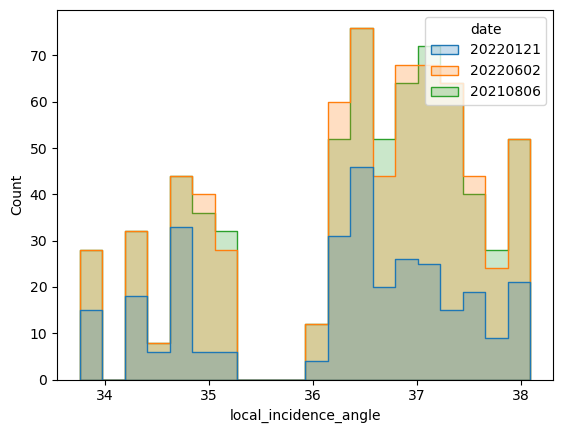

In [37]:
sns.histplot(data=stats_s1, x="local_incidence_angle", hue="date", element="step", bins=20)
plt.savefig(fig_out_dir / "s1-local_incidence_angle.png")

## Filter and combine stats

In [38]:
print("nova:", list(sorted(stats_novasar_df.date.unique().tolist())))
print("  s2:", list(sorted(stats_s2_df.date.unique())))
print("  s1:", list(sorted(stats_s1.date.unique().tolist())))

nova: ['20210807', '20220120', '20220601']
  s2: ['20210808', '20220120', '20220528', '20220604']
  s1: ['20210806', '20220121', '20220602']


In [39]:
novasar_s2_date_mapping = {
    # novsar : s2_date
    "20210807": "20210808", 
    "20220601": "20220604",
    "20220120": "20220120",
}
s1_s2_date_mapping = {
    # s1_date : s2_date
    "20210806": "20210808", 
    "20220602": "20220604",
    "20220121": "20220120",
}

In [40]:
_s2_date_of_novasar_img = stats_novasar_df.loc[:, "date"].map(lambda d: novasar_s2_date_mapping[d]).copy()
stats_novasar_df.loc[:, "s2_date"] = _s2_date_of_novasar_img
stats_novasar_df = stats_novasar_df[stats_novasar_df.loc[:, "s2_date"] != ""]

In [41]:
_s2_date_of_s1_img = stats_s1.loc[:, "date"].map(lambda d: s1_s2_date_mapping[d]).copy()
stats_s1.loc[:, "s2_date"] = _s2_date_of_s1_img

In [42]:
joined_novasar = stats_novasar_df.merge(right=stats_s2_df,  
                                        how="outer",
                                        left_on=('polygon_id', 's2_date'), 
                                        right_on=('polygon_id', "date"), 
                                        suffixes=('_novasar', '_s2'))
joined_novasar = joined_novasar[~pd.isna(joined_novasar.date_novasar)]
joined_novasar = joined_novasar[~pd.isna(joined_novasar.date_s2)]
joined_novasar.to_csv(fig_out_dir / "statistics-novasar-ndvi.csv")
joined_novasar

,mean_novasar,median_novasar,count_novasar,polygon_id,filename_novasar,local_incidence_angle,polarization,date_novasar,s2_date,mean_s2,median_s2,count_s2,filename_s2,date_s2
0,-8.999235,-8.755424,1841.0,0,/run/media/tom/SSDThomas/scratch/2024-05-s-ban...,21.270702,HH,20210807,20210808,0.907761,0.915452,7389.0,S2A_MSIL2A_20210808T002101_N0500_R116_T54HYF_2...,20210808
1,-17.795271,-17.243965,1841.0,0,/run/media/tom/SSDThomas/scratch/2024-05-s-ban...,21.270702,HV,20210807,20210808,0.907761,0.915452,7389.0,S2A_MSIL2A_20210808T002101_N0500_R116_T54HYF_2...,20210808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2619,-8.904404,10.947514,72.0,173,/run/media/tom/SSDThomas/scratch/2024-05-s-ban...,20.084316,CRVV,20220601,20220604,0.932867,0.934083,300.0,S2A_MSIL2A_20220604T002101_N0400_R116_T54HYF_2...,20220604
2620,0.262605,0.186906,72.0,173,/run/media/tom/SSDThomas/scratch/2024-05-s-ban...,20.084316,RVI,20220601,20220604,0.932867,0.934083,300.0,S2A_MSIL2A_20220604T002101_N0400_R116_T54HYF_2...,20220604


In [43]:
joined_s1 = stats_s1.merge(right=stats_s2_df,  
                                how="outer",
                                left_on=('polygon_id', 's2_date'), 
                                right_on=('polygon_id', "date"), 
                                suffixes=('_s1', '_s2'))
joined_s1 = joined_s1[~pd.isna(joined_s1.date_s1)]
joined_s1 = joined_s1[~pd.isna(joined_s1.date_s2)]
joined_s1.to_csv(fig_out_dir / "statistics-sentinel1-ndvi.csv")
joined_s1

,mean_s1,median_s1,count_s1,polygon_id,filename_s1,polarization,local_incidence_angle,date_s1,s2_date,mean_s2,median_s2,count_s2,filename_s2,date_s2
0,-13.271251,-13.170288,9127.0,0,Subset_S1A_IW_GRDH_1SDV_20210806T194104_202108...,VV,36.809937,20210806,20210808,0.907761,0.915452,7389.0,S2A_MSIL2A_20210808T002101_N0500_R116_T54HYF_2...,20210808
1,-18.679852,-18.479534,9127.0,0,Subset_S1A_IW_GRDH_1SDV_20210806T194104_202108...,VH,36.809937,20210806,20210808,0.907761,0.915452,7389.0,S2A_MSIL2A_20210808T002101_N0500_R116_T54HYF_2...,20210808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1862,-13.774843,6.264059,366.0,173,Subset_S1A_IW_GRDH_1SDV_20220602T194106_202206...,CR,34.816032,20220602,20220604,0.932867,0.934083,300.0,S2A_MSIL2A_20220604T002101_N0400_R116_T54HYF_2...,20220604
1863,0.831538,0.819408,366.0,173,Subset_S1A_IW_GRDH_1SDV_20220602T194106_202206...,RVI,34.816032,20220602,20220604,0.932867,0.934083,300.0,S2A_MSIL2A_20220604T002101_N0400_R116_T54HYF_2...,20220604


# Visualisierung

## single band distributions

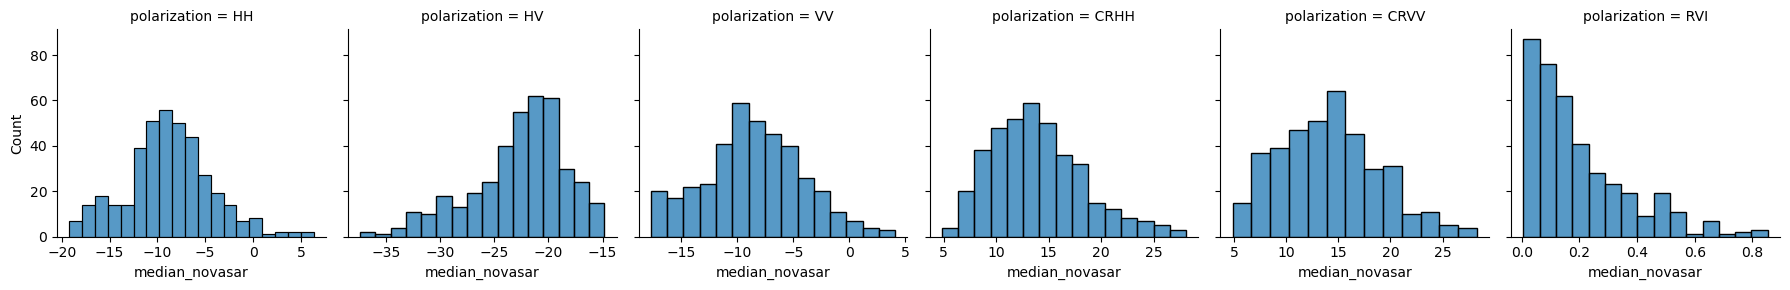

In [44]:
g = sns.FacetGrid(data=joined_novasar, col="polarization", sharex=False)
g.map_dataframe(sns.histplot, x="median_novasar")
plt.savefig(fig_out_dir / f"datahistogram-novasar-alldatatypes.png")

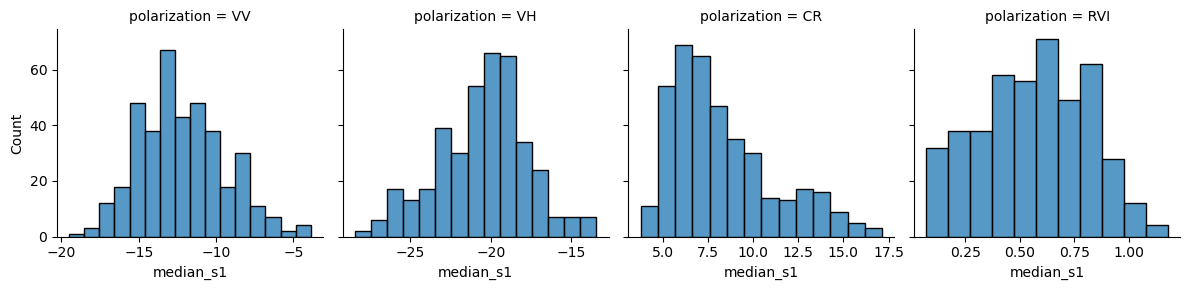

In [45]:
g = sns.FacetGrid(data=joined_s1, col="polarization", sharex=False)
g.map_dataframe(sns.histplot, x="median_s1")
plt.savefig(fig_out_dir / f"datahistogram-s1-alldatatypes.png")

## NovaSAR

In [46]:
sensor = "novasar"

In [47]:
_joined = joined_novasar.copy()
print(_joined.date_s2.unique())
_joined = _joined[_joined.mean_s2 < .97]

['20210808' '20220604' '20220120']


#### Color: Incidence angle

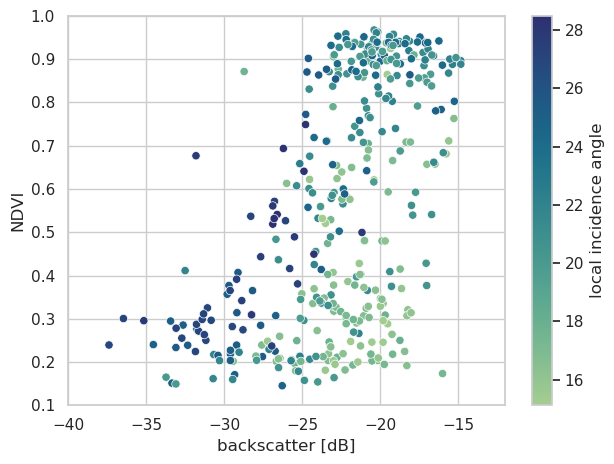

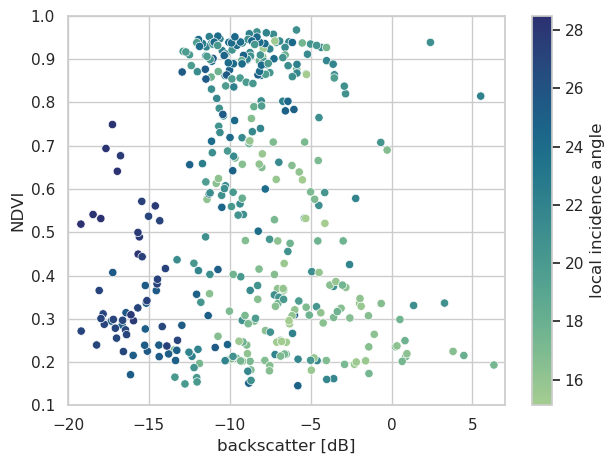

High p value! 0.955


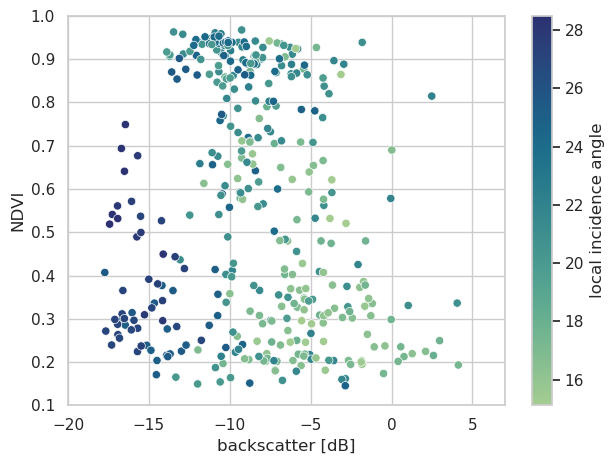

High p value! 0.009


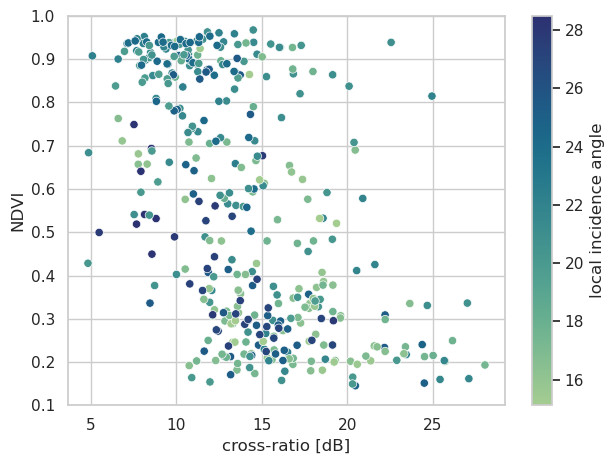

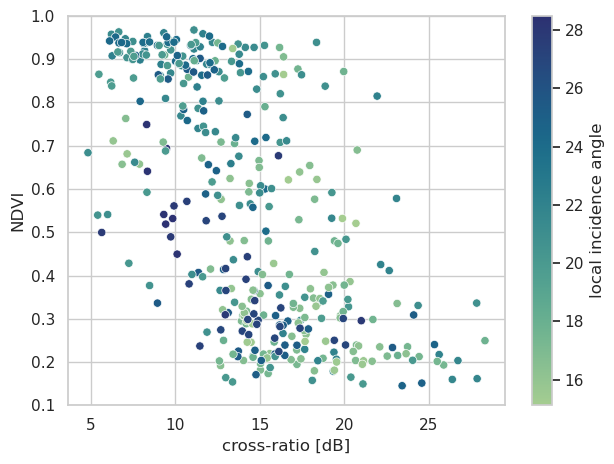

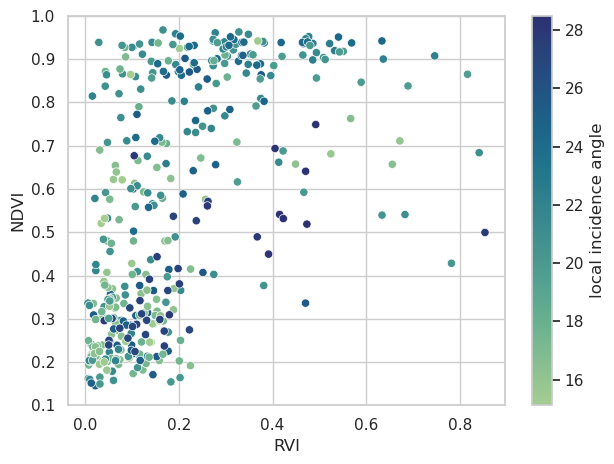

In [48]:
datanames = ["HV", "HH", "VV", "CRHH", "CRVV", "RVI"]
xlables = 3*["backscatter [dB]"] + 2*["cross-ratio [dB]",] + ["RVI"]
xlims = [(-40, -12), (-20, 7), (-20, 7), None, None, None]

for dataname, xlabel, xlim in zip(datanames, xlables, xlims):
    joined_pol = _joined[_joined.polarization == dataname]
    scatterplot_nice(x="median_novasar", y="median_s2", hue="local_incidence_angle", 
                     data=joined_pol,
                     xlabel=xlabel, ylabel="NDVI", huelabel="local incidence angle",
                     xlim=xlim,
                     title=None)
    plt.savefig(fig_out_dir / f"novasar-{dataname.lower()}-ndvi-s2.pdf")
    plt.show()
    pearsonsr_pol = get_filtered_pearsons_r(x="median_novasar", y="median_s2", data=joined_pol)
    correlation_coeffs.append({"sensor": sensor, "polarization": dataname, "r": pearsonsr_pol["r"], "N": 
                               pearsonsr_pol["N"], "p": pearsonsr_pol["p"]})

#### color: date

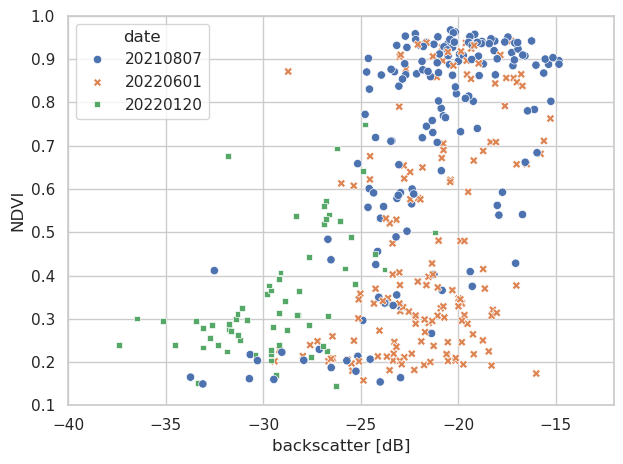

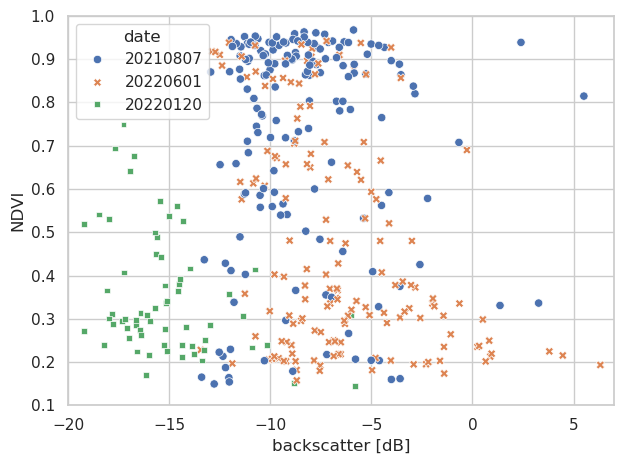

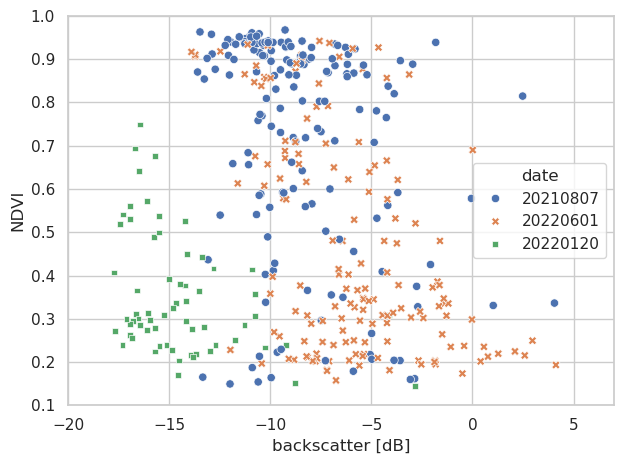

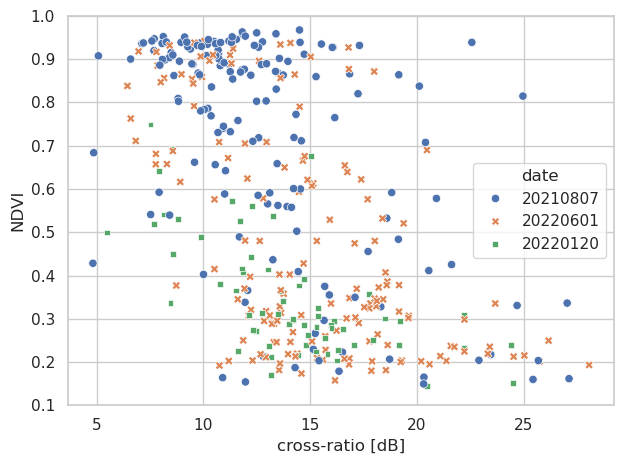

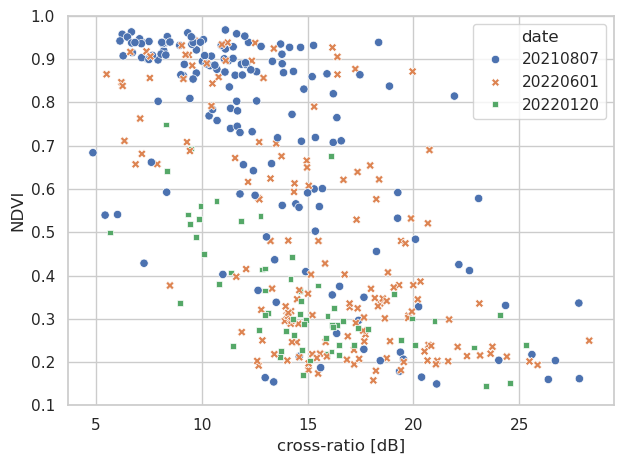

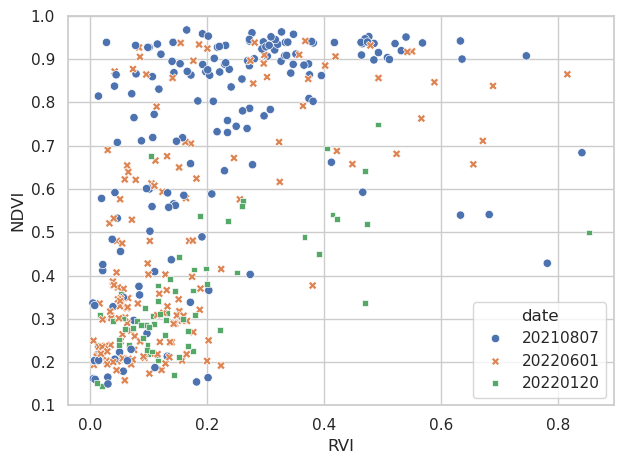

In [49]:
for dataname, xlabel, xlim in zip(datanames, xlables, xlims):
    joined_pol = _joined[_joined.polarization == dataname]
    scatterplot_nice(x="median_novasar", y="median_s2", hue="date_novasar", style="date_novasar",
                     data=joined_pol,
                     xlabel=xlabel, ylabel="NDVI", huelabel="date",
                     xlim=xlim,
                     title=None)
    plt.savefig(fig_out_dir / f"novasar-{dataname.lower()}-ndvi-s2-datecolor.pdf")
    plt.show()

## Sentinel-1

In [50]:
sensor = "S1"

In [51]:
_joined = joined_s1.copy()
_joined = _joined[_joined.mean_s2 < .98]
print("dates:", _joined.date_s1.unique())

dates: ['20210806' '20220602' '20220121']


In [52]:
datanames = ["VV", "VH", "CR", "RVI"]
xlables = ["backscatter [dB]", "backscatter [dB]", "cross-ratio [dB]", "RVI"]
xlims = [(-22.5, -2.5), (-30, -11), None, None]

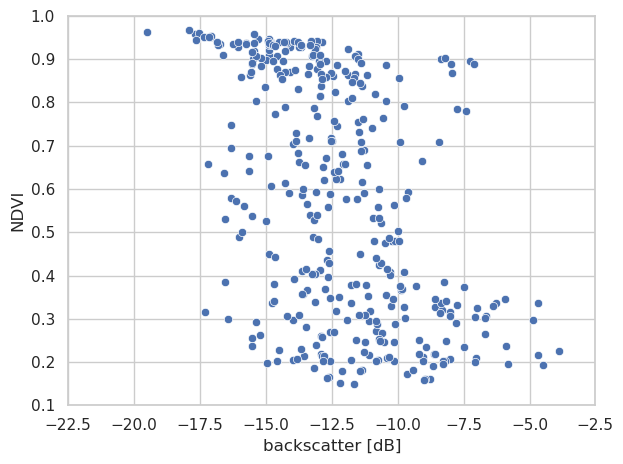

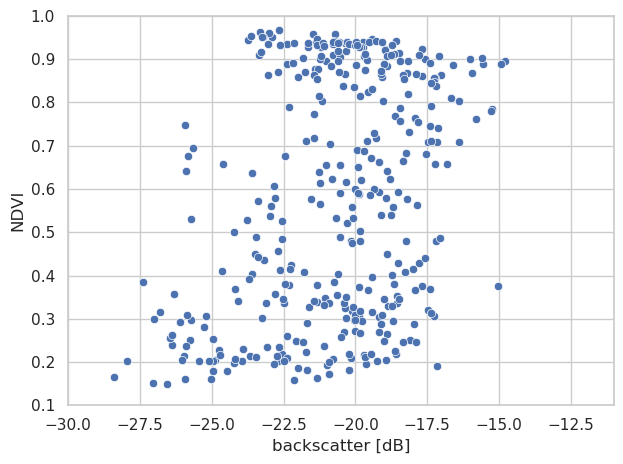

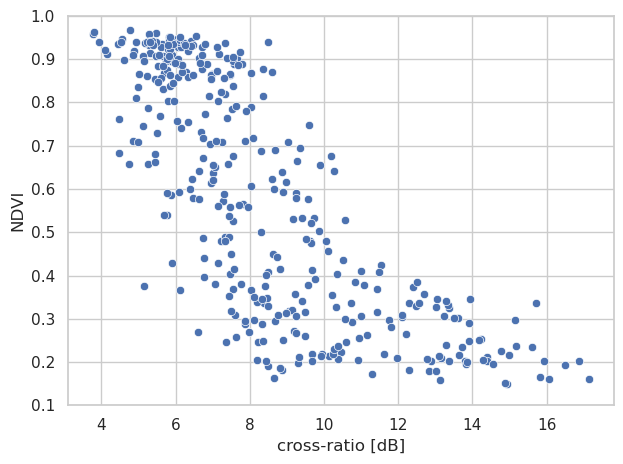

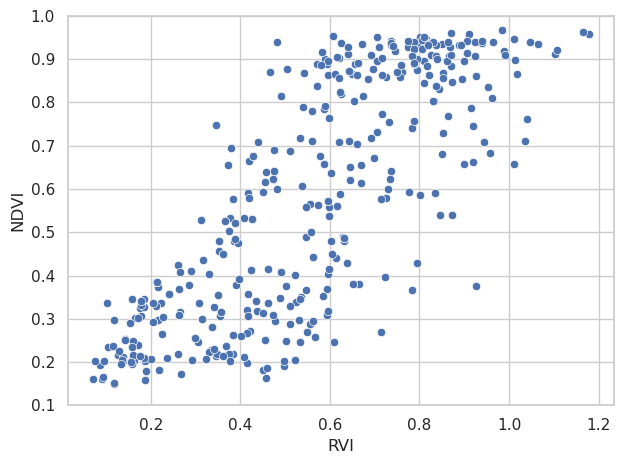

In [53]:
for dataname, xlabel, xlim in zip(datanames, xlables, xlims):
    joined_pol = _joined[_joined.polarization == dataname]
    scatterplot_nice(x="median_s1", y="median_s2", data=joined_pol,
                     xlabel=xlabel, ylabel="NDVI",
                     xlim=xlim
                    )
    plt.savefig(fig_out_dir / f"s1-{dataname.lower()}-ndvi-s2.pdf")
    plt.show()
    pearsonsr_pol = get_filtered_pearsons_r(x="median_s1", y="median_s2", data=joined_pol)
    correlation_coeffs.append({"sensor": sensor, "polarization": dataname, "r": pearsonsr_pol["r"], "N": 
                               pearsonsr_pol["N"], "p": pearsonsr_pol["p"]})


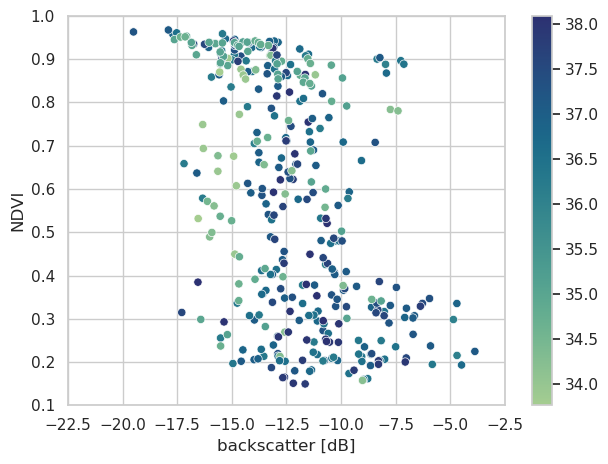

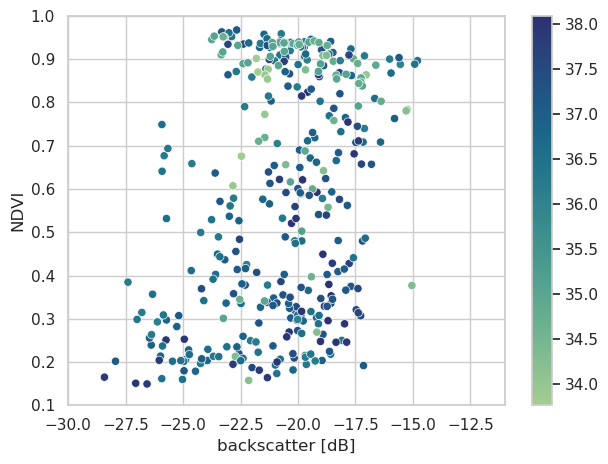

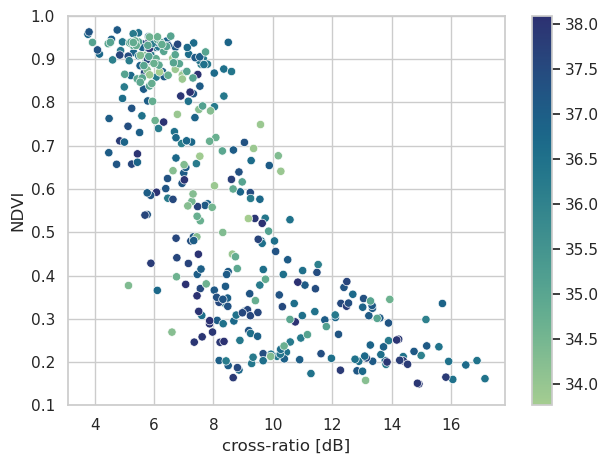

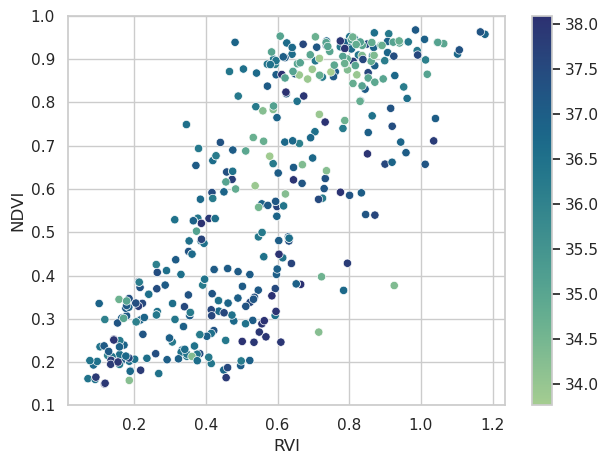

In [54]:
for dataname, xlabel, xlim in zip(datanames, xlables, xlims):
    joined_pol = _joined[_joined.polarization == dataname]
    scatterplot_nice(x="median_s1", y="median_s2", data=joined_pol,
                     hue="local_incidence_angle",
                     xlabel=xlabel, ylabel="NDVI",
                     xlim=xlim,
                     title="")
    plt.savefig(fig_out_dir / f"s1-{dataname.lower()}-ndvi-s2-colorincidence.pdf")
    plt.show()

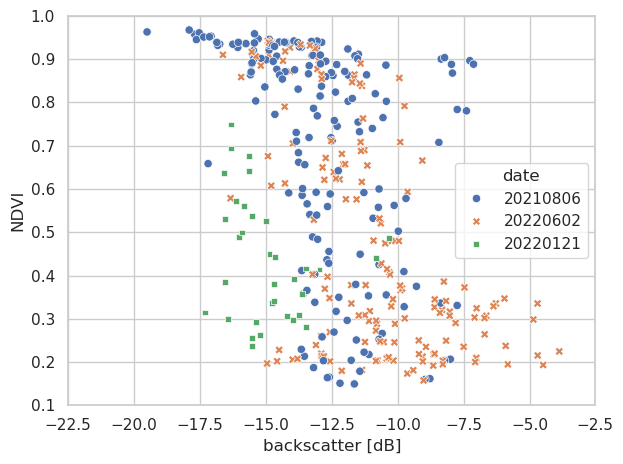

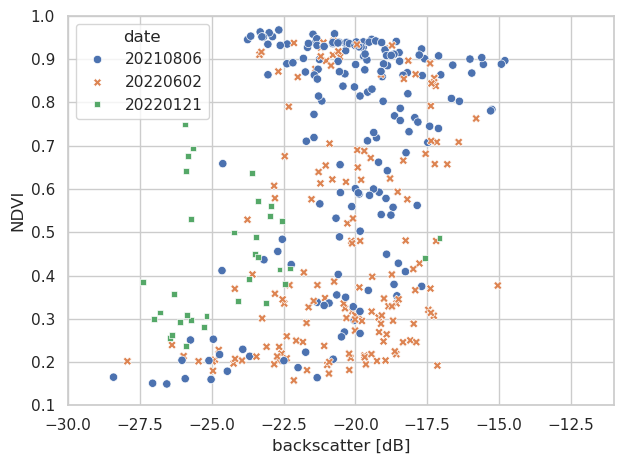

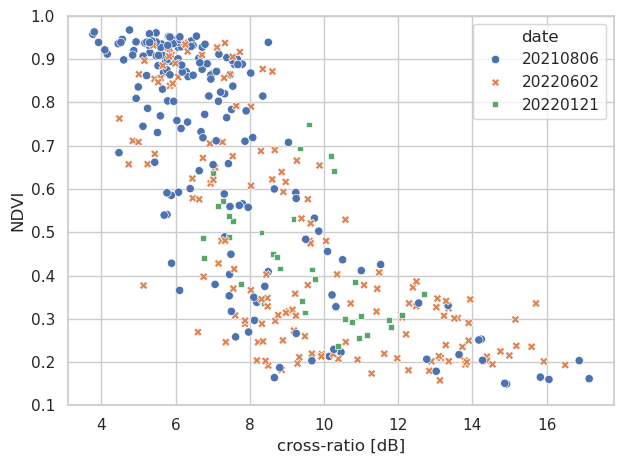

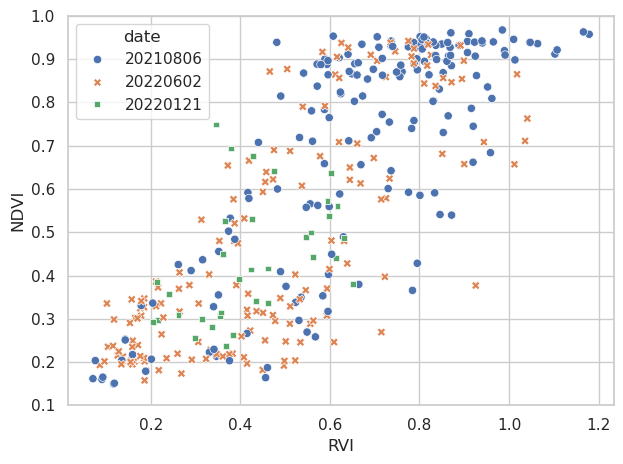

In [55]:
for dataname, xlabel, xlim in zip(datanames, xlables, xlims):
    joined_pol = _joined[_joined.polarization == dataname]
    scatterplot_nice(x="median_s1", y="median_s2", hue="date_s1", style="date_s1",
                     data=joined_pol,
                     xlabel=xlabel, ylabel="NDVI", huelabel="date",
                     xlim=xlim,
                     title="")
    plt.savefig(fig_out_dir / f"s1-{dataname.lower()}-ndvi-s2-colordate.pdf")
    plt.show()

# correlation table

In [56]:
pearsonsr_df = pd.DataFrame(correlation_coeffs)
print(pearsonsr_df[["sensor", "polarization", "N","r", "p"]].to_markdown())
print(pearsonsr_df[["sensor", "polarization", "N","r", "p"]].style.format({"r": '{:.2f}', "p": "{:.3f}"},).to_latex(hrules=True))

|    | sensor   | polarization   |   N |           r |           p |
|---:|:---------|:---------------|----:|------------:|------------:|
|  0 | novasar  | HV             | 366 |  0.535748   | 1.40824e-28 |
|  1 | novasar  | HH             | 366 |  0.00299191 | 0.954511    |
|  2 | novasar  | VV             | 366 | -0.137321   | 0.0085238   |
|  3 | novasar  | CRHH           | 366 | -0.545799   | 8.439e-30   |
|  4 | novasar  | CRVV           | 366 | -0.643126   | 4.17811e-44 |
|  5 | novasar  | RVI            | 366 |  0.587768   | 2.23233e-35 |
|  6 | S1       | VV             | 348 | -0.446356   | 1.9233e-18  |
|  7 | S1       | VH             | 347 |  0.315146   | 1.93729e-09 |
|  8 | S1       | CR             | 348 | -0.756922   | 6.73355e-66 |
|  9 | S1       | RVI            | 382 |  0.775963   | 4.72613e-78 |
\begin{tabular}{lllrrr}
\toprule
 & sensor & polarization & N & r & p \\
\midrule
0 & novasar & HV & 366 & 0.54 & 0.000 \\
1 & novasar & HH & 366 & 0.00 & 0.955 \\
2 & nova